In [ ]:
%load_ext autoreload
%autoreload 2 # Automatically reload modules before executing code (without having to restart the kernel)

import sys
from pathlib import Path
import matplotlib.pyplot as plt

project_root = Path("/dmj/fizmed/mmarzec/licencjat_neuro/magisterka")
sys.path.insert(0, str(project_root / "src"))

In [2]:
from preprocessing.processing import EEGPreprocessor # type:ignore
from preprocessing.windowing import EEGWindower # type:ignore
from preprocessing.frame_selector import EEGFrameSelector # type:ignore
from preprocessing.frame_exporter2 import EEGFrameExporter # type:ignore
from preprocessing.constants import ( # type:ignore
    BASE_DIR, BASE_CSV_PATH, EDF_DIR,
    CH_NAMES, VALID_1020, CHNAMES_MAPPING,
    FREQ_BANDS, FREQ_BANDS_NAMES,
    DEFAULT_NOTCH_FREQ, DEFAULT_NOTCH_Q,
    DEFAULT_HP_CUTOFF, DEFAULT_LP_CUTOFF, DEFAULT_MONTAGE,
    DEFAULT_SFREQ, DEFAULT_PERCENTILE, DEFAULT_IIR_ORDER
)  

/dmj/fizmed/mmarzec/licencjat_neuro/magisterka/src/preprocessing/processing.py


In [3]:
BASE_DIR, EDF_DIR, BASE_CSV_PATH # type:ignore

('/dmj/fizmed/mmarzec/licencjat_neuro',
 '/dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_edfs',
 '/dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_info.csv')

WYBÓR NAGRANIA EEG ZE SZPITALA SZC

In [4]:
import pandas as pd
data = pd.read_csv(BASE_CSV_PATH) # type:ignore
data_szc = data[data['institution_id'] == 'SZC']

In [5]:
data_szc

,examination_id,patient_original_id,age_dec,patient_sex,institution_id,classification
4,20220512-152511-{61074308-a109-40b1-97cb-43dcb...,{238385d0-7169-42a6-b94f-6ddbc4e08746},60.583333,Male,SZC,patho
5,20220512-151748-{5d0347f5-6902-47e3-aad0-8355e...,{2f50797c-774a-4611-814b-f6f8e3202111},62.916667,Female,SZC,patho
6,20220512-155641-{810f6d80-23e2-41ef-b68c-dee45...,{6d3f7d71-c7b6-448c-944e-21546debbfe2},54.750000,Female,SZC,patho
9,20220512-153216-{bfa23f5b-5051-431c-a77f-dff01...,{bb2ce00d-0036-4696-a80c-a99ffc5663fb},30.166667,Female,SZC,patho
13,20220512-165737-{d5acb6d0-b682-42c1-9362-001a9...,{575c950a-c4ed-496b-9abb-31f4921dc152},16.833333,Male,SZC,norm
...,...,...,...,...,...,...
42517,20220512-151645-{433cd26e-fdcc-4df2-8262-6a585...,{1b986dca-28d8-40a4-8917-8a807b93f25f},41.250000,Female,SZC,norm
42518,20220512-160942-{80e473d0-76db-4688-bc62-35fe8...,{1b986dca-28d8-40a4-8917-8a807b93f25f},39.833333,Female,SZC,norm
42519,20220512-161121-{c5e5998f-63cb-4eba-a413-bb964...,{1b986dca-28d8-40a4-8917-8a807b93f25f},42.333333,Female,SZC,norm
42520,20220512-150750-{a4b3c83e-a4d6-4c2d-b036-4c420...,{ebb5d06c-a651-40d8-b22a-e126c3f82295},36.666667,Male,SZC,norm


In [9]:
label = data_szc['classification'].iloc[551]

In [10]:
edf_path = f"{EDF_DIR}/{data_szc['examination_id'].iloc[551]}.edf" # type:ignore
institution_id_szc = data_szc['institution_id'].iloc[551]

In [11]:
CHOICE_OF_REFERENCE = ["Cz"] # or average or Fz or Cz
CHOICE_OF_FRAME_LEN = 6
counter = 2

PREPROCESSING

In [12]:
preprocessor = EEGPreprocessor.from_edf(
    edf_path=edf_path,
    institution_id=institution_id_szc,
    preload=True
)

print(f"✓ Załadowano {len(preprocessor.raw.ch_names)} kanałów")
print(f"  Częstotliwość próbkowania: {preprocessor.raw.info['sfreq']} Hz")
print(f"  Czas trwania: {preprocessor.raw.times[-1]:.1f} s")
print(f"  Kanały: {preprocessor.raw.ch_names}")

Extracting EDF parameters from /dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_edfs/20220512-155621-{6183e5bc-9603-4bbd-858e-4e3ee2be99ca}.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 182999  =      0.000 ...   731.996 secs...
✓ Załadowano 19 kanałów
  Częstotliwość próbkowania: 250.0 Hz
  Czas trwania: 732.0 s
  Kanały: ['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG Fz', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG Cz', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG Pz', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2']


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Using matplotlib as 2D backend.


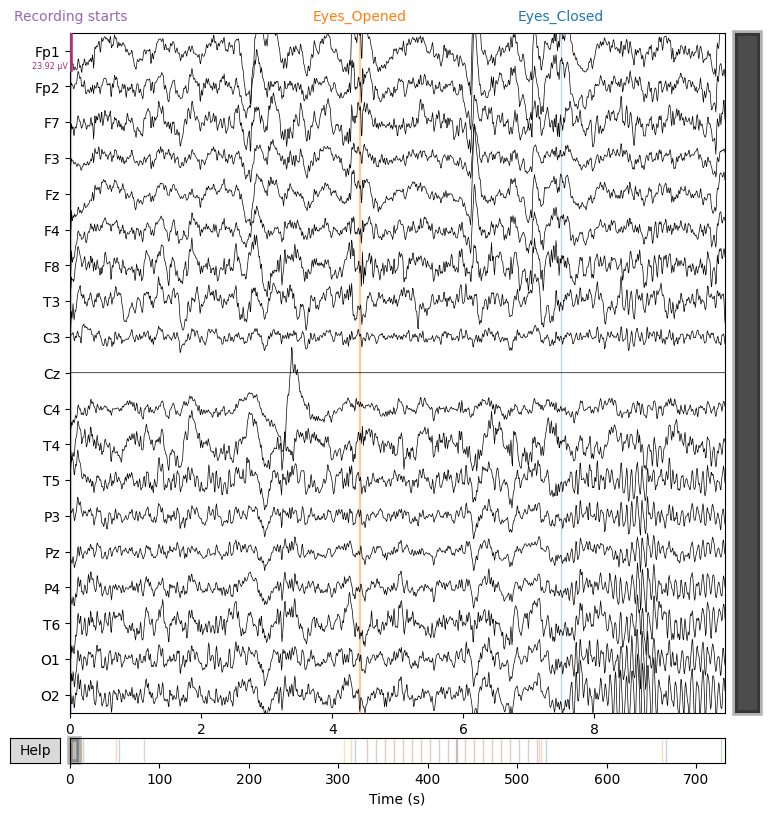


✓ Preprocessing zakończony!
  Kanały po standaryzacji: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
  Częstotliwość po resamplingu: 128.0 Hz


In [13]:
raw_preprocessed = preprocessor.preprocess(
    ref_channels=CHOICE_OF_REFERENCE,           # Referencja: average, 'Cz', 'Fz' lub lista kanałów 
    sfreq=DEFAULT_SFREQ,                        # Resample do 128 Hz
    notch_freq= DEFAULT_NOTCH_FREQ,             # Notch filter: 50 Hz (Europa) lub 60 Hz (USA)
    hp_cutoff= DEFAULT_HP_CUTOFF,               # High-pass: 0.5 Hz (usuwa dryft)
    lp_cutoff= DEFAULT_LP_CUTOFF,               # Low-pass: 45 Hz
    plot=True,                                  # Ustaw True aby zobaczyć sygnał
    percentile=DEFAULT_PERCENTILE               # Percentyl dla skalowania wykresu
)

print("\n✓ Preprocessing zakończony!")
print(f"  Kanały po standaryzacji: {raw_preprocessed.ch_names}")
print(f"  Częstotliwość po resamplingu: {raw_preprocessed.info['sfreq']} Hz")

WINDOWING -- SEGEMENTACJA NA RAMKI

In [14]:
windower = EEGWindower(raw_preprocessed)

Detected units: V
Typical amplitude: 2.69e-06 V


In [15]:
clean_frames, info = windower.process_fixed_frames(
    frame_duration= CHOICE_OF_FRAME_LEN,  # n-sekundowe ramki
    drop_last_incomplete=True,            # Usuń ostatnią niepełną ramkę
    min_amplitude=1.0,                    # < 1 µV = płaska (elektroda odłączona)
    max_amplitude=600.0,                  # > 600 µV = artefakt (ruch, mięśnie)
    min_flat_channels=10,                 # Min. kanałów płaskich do odrzucenia
    min_bad_channels=1,                   # Min. kanałów z artefaktem do odrzucenia
    verbose=True
)

print(f"\n✓ Segmentacja zakończona!")
print(f"  Shape ramek: {clean_frames.shape}")
print(f"  (n_frames, n_channels, n_samples_per_frame)")

Segmentation Info:
  Recording duration: 732.0s
  Frame duration: 6s (768 samples @ 128.0Hz)
  Total frames: 122

Frame Rejection Summary:
  Data units: V
  Thresholds: 1.0 µV = 1.00e-06 V, 600.0 µV = 6.00e-04 V
  Total frames: 122
  Rejected: 0 (0.0%)
    - Flat (< 1.0 µV): 0
    - High amplitude (> 600.0 µV): 0
  Clean frames: 122

✓ Segmentacja zakończona!
  Shape ramek: (122, 19, 768)
  (n_frames, n_channels, n_samples_per_frame)


FRAME SELECTOR

In [16]:
selector = EEGFrameSelector.from_windower_results(
    raw=raw_preprocessed,
    windower=windower,
    process_info=info
)

print(f"✓ Selector zainicjalizowany")
print(f"  Clean frames: {len(selector.clean_frames)}")
print(f"  Shape: {selector.clean_frames.shape}")

✓ Selector zainicjalizowany
  Clean frames: 122
  Shape: (122, 19, 768)


In [17]:
annotation_counts = selector.list_annotations(verbose=True)

AVAILABLE ANNOTATIONS
  1. Recording starts (n=1, point marker)
  2. Eyes_Opened (n=6, point marker)
  3. Eyes_Closed (n=6, point marker)
  4. Stimulation_PhotostimulationStart (n=1, point marker)
  5. Stimulation_PhotostimulationStop (n=1, point marker)
  6. Stimulation_HyperventilationStart (n=20, point marker)
  7. Stimulation_HyperventilationStop (n=1, point marker)
  8. Recording ends (n=1, point marker)


FRAME GROUPING AND EXPORTING

In [19]:
exporter = EEGFrameExporter(
    selector=selector,
    output_dir=f"results/demoDTF/{counter}")#, exclude_events=['Recording starts', 'Recording ends'])

In [20]:
event_groups = exporter.get_valid_events(verbose=True)

AttributeError: 'EEGFrameExporter' object has no attribute 'get_valid_events'

In [20]:
groups = selector.create_groups(
    event_groups=event_groups,
    match_mode='contains',
    store=True,
    verbose=True
)


SPLITTING FRAMES BY EVENTS

Group: eyes_opened
----------------------------------------
Event-based Frame Selection:
  Searched events: [np.str_('Eyes_Opened')]
  Match mode: contains
  Events found: 6
  Point markers (duration=0): 6/6
  Total clean frames: 122
  Frames with events: 6 (4.9%)

  Event details:
    1. Eyes_Opened: 4.4s (point marker)
    2. Eyes_Opened: 12.0s (point marker)
    3. Eyes_Opened: 51.7s (point marker)
    4. Eyes_Opened: 314.5s (point marker)
    5. Eyes_Opened: 526.6s (point marker)
    ... and 1 more events

Group: eyes_closed
----------------------------------------
Event-based Frame Selection:
  Searched events: [np.str_('Eyes_Closed')]
  Match mode: contains
  Events found: 6
  Point markers (duration=0): 6/6
  Total clean frames: 122
  Frames with events: 6 (4.9%)

  Event details:
    1. Eyes_Closed: 7.5s (point marker)
    2. Eyes_Closed: 14.7s (point marker)
    3. Eyes_Closed: 55.0s (point marker)
    4. Eyes_Closed: 318.2s (point marker)
    5. E

In [21]:
saved_files = exporter.save_frames(
    groups=groups,
    source_file=edf_path,
    compress=True,
    verbose=True
)


SAVING FRAMES

Group: eyes_opened
  Frames: 6, Shape: (6, 19, 768)
  ✓ Saved: eyes_opened_frames_20251213_141633.npz (622.3 KB)

Group: eyes_closed
  Frames: 6, Shape: (6, 19, 768)
  ✓ Saved: eyes_closed_frames_20251213_141633.npz (622.7 KB)

Group: stimulation_photostimulationstart
  Frames: 1, Shape: (1, 19, 768)
  ✓ Saved: stimulation_photostimulationstart_frames_20251213_141633.npz (105.9 KB)

Group: stimulation_photostimulationstop
  Frames: 1, Shape: (1, 19, 768)
  ✓ Saved: stimulation_photostimulationstop_frames_20251213_141633.npz (106.0 KB)

Group: stimulation_hyperventilationstart
  Frames: 20, Shape: (20, 19, 768)
  ✓ Saved: stimulation_hyperventilationstart_frames_20251213_141633.npz (2069.2 KB)

Group: stimulation_hyperventilationstop
  Frames: 1, Shape: (1, 19, 768)
  ✓ Saved: stimulation_hyperventilationstop_frames_20251213_141633.npz (105.9 KB)

✓ Saved 6 groups to results/demoDTF/2/frames


In [22]:
plot_files = exporter.visualize_all_groups(
    groups=groups,
    dpi=150,
    show=False,
    verbose=True
)


GENERATING VISUALIZATIONS

Group: eyes_opened
  ✓ Trace: eyes_opened_example_trace.png
  ✓ Overview: eyes_opened_overview.png
  ✓ Timeline: eyes_opened_timeline.png

Group: eyes_closed
  ✓ Trace: eyes_closed_example_trace.png
  ✓ Overview: eyes_closed_overview.png
  ✓ Timeline: eyes_closed_timeline.png

Group: stimulation_photostimulationstart
  ✓ Trace: stimulation_photostimulationstart_example_trace.png
  ✓ Overview: stimulation_photostimulationstart_overview.png
  ✓ Timeline: stimulation_photostimulationstart_timeline.png

Group: stimulation_photostimulationstop
  ✓ Trace: stimulation_photostimulationstop_example_trace.png
  ✓ Overview: stimulation_photostimulationstop_overview.png
  ✓ Timeline: stimulation_photostimulationstop_timeline.png

Group: stimulation_hyperventilationstart
  ✓ Trace: stimulation_hyperventilationstart_example_trace.png
  ✓ Overview: stimulation_hyperventilationstart_overview.png
  ✓ Timeline: stimulation_hyperventilationstart_timeline.png

Group: stimulatio